In [8]:
from abc import ABC, abstractmethod
import pathlib
import pandas as pd
import seaborn as sns
import lxml.html
from bs4 import BeautifulSoup
import timeit

In [105]:
class Comparison(ABC):

    examples = ["asha_bhosle", "html5test", "nba", "python"]

    def __init__(self):
        self.html = {}
        for example in self.examples:
            self.html[example] = (
                pathlib.Path("testdata") / f"{example}.html"
            ).read_text()

    def pre_parse(self):
        # Pre-parse the HTML to allow us to benchmark individual selections
        self.root = {}
        for name, html in self.html.items():
            self.root[name] = self.load_dom(name)


In [106]:
class Lxml(Comparison):
    def load_dom(self, example):
        return lxml.html.fromstring(self.html[example])

    def links_natural(self, example):
        return self.root[example].xpath("//a/@href")

    def links_css(self, example):
        return self.root[example].cssselect("a[href]")

    def count_elements(self, example):
        elems = []
        for e in self.root[example].iter():
            elems.append(e)
        return elems

    def extract_text(self, example):
        return self.root[example].text_content()

    def __repr__(self):
        return "lxml.html"

In [107]:
class BSoup(Comparison):
    def __init__(self, parser):
        super().__init__()
        self.parser = parser

    def load_dom(self, example):
        return BeautifulSoup(self.html[example], self.parser)

    def links_natural(self, example):
        return self.root[example].find_all("a", href=True)

    def links_css(self, example):
        return self.root[example].select("a[href]")

    def count_elements(self, example):
        elems = [e for e in self.]
        for e in self.root[example].recursiveChildGenerator():
            elems.append(e)
        return elems

    def extract_text(self, example):
        return self.root[example].get_text()

    def __repr__(self):
        return f"BeautifulSoup[{self.parser}]"

In [108]:
impls = [
    Lxml(), BSoup("html.parser"), BSoup("html5lib"), BSoup("lxml")
]


In [109]:
def run_speed_test(implementations, method, number):
    """
    Run a speed test on a method of each implementation.
    """
    runs = []
    for obj in implementations:
        for example in Comparison.examples:
            result = timeit.timeit(
                "method(example)",
                globals={"method": getattr(obj, method), "example": example},
                number=number,
            )
            runs.append({"implementation": str(obj), "example": example, "time": result / number})
            # print(obj, example, "\n", result)
    return pd.DataFrame(runs)

In [130]:
def show_results(df, name):
    """
    Show relative times and overall graph for benchmark.
    """
    sns.set_theme(style="white")
    ax = sns.barplot(df[df.example != "html5test"], x="example", y="time", hue="implementation")
    ax.set_ylabel("Avg. Time (s)")
    ax.set_xlabel("Example HTML")
    ax.set_title(name)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    # ax = sns.barplot(df[df.example == "html5test"], x="example", y="time", hue="implementation")
    # ax.set_ylabel("Avg. Time (s)")
    # ax.set_xlabel("Example HTML")
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    means = df.groupby("implementation").mean(numeric_only=True)
    means /= means.loc["lxml.html"]
    print(means)

In [131]:
def compare_results(implementations, method):
    """ 
    Show output of a method for each implementation to ensure
    they are all producing the same results
    """
    runs = []
    for obj in implementations:
        for example in Comparison.examples:
            count = len(getattr(obj, method)(example))
            runs.append({"implementation": str(obj), "example": example, "count": count})
    return pd.DataFrame(runs)

lxml.html asha_bhosle
lxml.html html5test
lxml.html nba
lxml.html python
BeautifulSoup[html.parser] asha_bhosle
BeautifulSoup[html.parser] html5test
BeautifulSoup[html.parser] nba
BeautifulSoup[html.parser] python
BeautifulSoup[html5lib] asha_bhosle
BeautifulSoup[html5lib] html5test
BeautifulSoup[html5lib] nba
BeautifulSoup[html5lib] python
BeautifulSoup[lxml] asha_bhosle
BeautifulSoup[lxml] html5test
BeautifulSoup[lxml] nba
BeautifulSoup[lxml] python
                                 time
implementation                       
BeautifulSoup[html.parser]  13.336535
BeautifulSoup[html5lib]     30.812903
BeautifulSoup[lxml]         10.704690
lxml.html                    1.000000


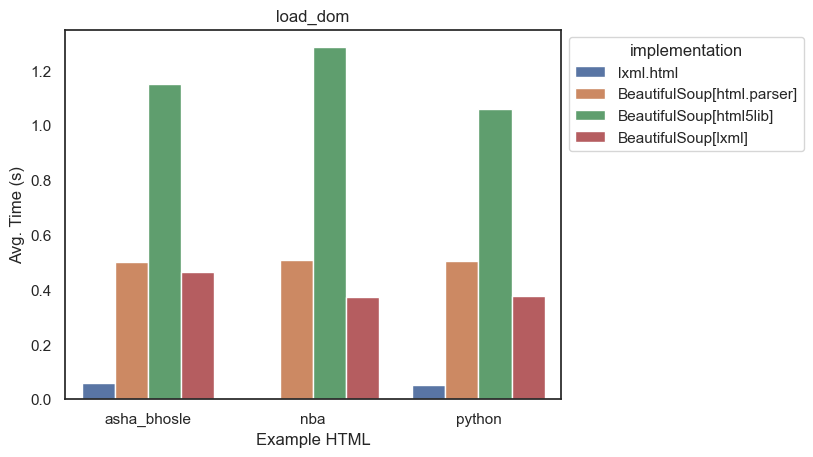

In [132]:

df = run_speed_test(impls, "load_dom", 1)
show_results(df, "load_dom")

lxml.html asha_bhosle
lxml.html html5test
lxml.html nba
lxml.html python
BeautifulSoup[html.parser] asha_bhosle
BeautifulSoup[html.parser] html5test
BeautifulSoup[html.parser] nba
BeautifulSoup[html.parser] python
BeautifulSoup[html5lib] asha_bhosle
BeautifulSoup[html5lib] html5test
BeautifulSoup[html5lib] nba
BeautifulSoup[html5lib] python
BeautifulSoup[lxml] asha_bhosle
BeautifulSoup[lxml] html5test
BeautifulSoup[lxml] nba
BeautifulSoup[lxml] python
                                time
implementation                      
BeautifulSoup[html.parser]  6.946812
BeautifulSoup[html5lib]     7.052382
BeautifulSoup[lxml]         7.383876
lxml.html                   1.000000


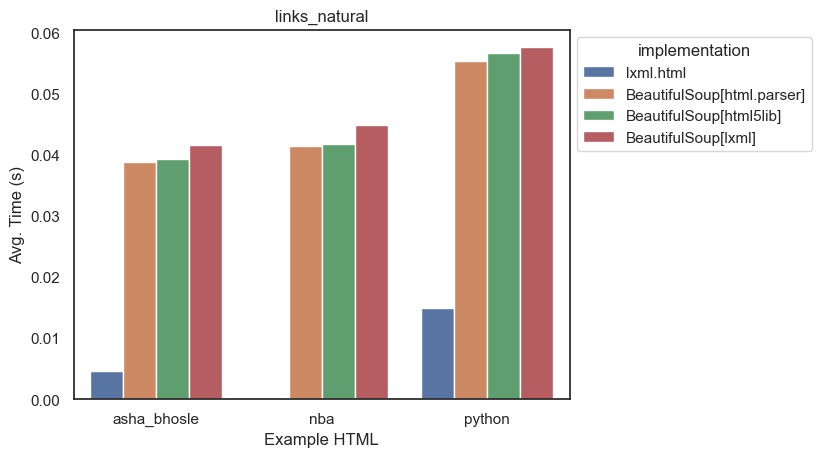

In [129]:
_ = [impl.pre_parse() for impl in impls]
df = run_speed_test(impls, "links_natural", 1)
show_results(df, "links_natural")

In [134]:
compare_results(impls, "links_natural")

,implementation,example,count
0,lxml.html,asha_bhosle,2511
1,lxml.html,html5test,13
2,lxml.html,nba,0
3,lxml.html,python,17229
4,BeautifulSoup[html.parser],asha_bhosle,2511
5,BeautifulSoup[html.parser],html5test,13
6,BeautifulSoup[html.parser],nba,9321
7,BeautifulSoup[html.parser],python,17229
8,BeautifulSoup[html5lib],asha_bhosle,2511
9,BeautifulSoup[html5lib],html5test,13


In [136]:
compare_results(impls, "links_css")

,implementation,example,count
0,lxml.html,asha_bhosle,2511
1,lxml.html,html5test,13
2,lxml.html,nba,0
3,lxml.html,python,17229
4,BeautifulSoup[html.parser],asha_bhosle,2511
5,BeautifulSoup[html.parser],html5test,13
6,BeautifulSoup[html.parser],nba,9321
7,BeautifulSoup[html.parser],python,17229
8,BeautifulSoup[html5lib],asha_bhosle,2511
9,BeautifulSoup[html5lib],html5test,13


In [137]:
compare_results(impls, "count_elements")

TypeError: compare_results() missing 1 required positional argument: 'method'